![paleoCAMP logo](./images/paleoCAMPLogo.png)

# Additional information and examples


**Tutorial at [the 2024 paleoCAMP](https://paleoclimate.camp/) | June 18–July 1, 2024**  

       
[Jiang Zhu](https://staff.cgd.ucar.edu/jiangzhu/)  
[jiangzhu@ucar.edu](mailto:jiangzhu@ucar.edu)  
Climate & Global Dynamics Laboratory  
NSF National Center for Atmospheric Research  

------

**More information and examples to demonstrate model data access and analysis using the NCAR JupyterHub**
* Further Info 1: Guidance on using climate data
* Further Info 2: Access ESM output
* Example 1: Access CESM output on NCAR's Campaign Storage and perform model-data comparison 
* Example 2: Access ERA5 Reanalysis on NSF NCAR's Research Data Archive
* Example 3: Plot AMOC from TraCE and compare with McManus et al. 2004
* Example 4. Compute and plot precipitation δ18O

**Time to go through**: 10 minutes

---
## Further Info 1: Guidance on using climate data
- NCAR [Climate Data Guide](https://climatedataguide.ucar.edu/): Key strength, Key limitations, Expert User Guidance, etc.
  - [Atmospheric Reanalysis: Overview & Comparison Tables](https://climatedataguide.ucar.edu/climate-data/atmospheric-reanalysis-overview-comparison-tables)
  - [Paleoclimate](https://climatedataguide.ucar.edu/climate-data/paleoclimate) (You could contribute!)
  - ...

---
## Further Info 2: Access ESM output
- Earth System Grid Federation (ESGF), e.g., the [LLNL Node](https://aims2.llnl.gov/search)
- NCAR [Climate Data Gateway](https://www.earthsystemgrid.org/), e.g., the iTRACE
- NCAR [Research Data Archive](https://rda.ucar.edu/): e.g., EAR5 Reanalysis (1.77 PB!)
- Other portals, such as the [DeepMIP Model Database](https://www.deepmip.org/data-eocene/)
- **NCAR [JupyterHub](https://jupyterhub.hpc.ucar.edu/) is your `one-stop shop` for CESM data and analysis!**
  - Multiple PB of CESM Paleoclimate simulation data
  - Other CESM simulation data
  - Preinstalled Python environment

Note: variable names may be different depending on the portals ([IPCC Standard](https://pcmdi.llnl.gov/mips/cmip3/variableList.html); [CESM Standard](https://www.cesm.ucar.edu/community-projects/lens2/output-variables))

---
Load Python packages

In [1]:
import os
import glob
from datetime import timedelta

import xarray as xr
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point

# xesmf is used for regridding ocean output
import xesmf

import warnings
warnings.filterwarnings("ignore")

---
## Example 1: Access CESM paleoclimate output and perform model-data comparison on NCAR's Campaign Storage
- We try to reproduce [Figure 2a of Jiang's paper](https://dx.doi.org/10.1029/2020GL091220) to use the LGM ΔSST to assess CESM2's climate sensitivity.
- Whole set of model output is shared at: `/glade/campaign/cesm/development/palwg`
- You can find additional simulation data here: `/glade/campaign/cgd/ppc/jiangzhu`
- We are in the process of organizing available data on the [Paleoclimate Working Group webiste](https://www.cesm.ucar.edu/working-groups/paleo)
- As for now, prior knowledge of the experiments and file structure are needed. ***We hope to develop a Simulation Catalog for this!***

In [2]:
!ls /glade/campaign/cesm/development/palwg/

cesm                        Idealized           old.setups
CMIP_DECK                   inputdata           paleoweather
ctsm_glacier_gridfiles_LGM  LastGlacialMaximum  pliocene
datasets                    LastInterglacial    Pliocene
EXTRA                       LastMillennium      raw_boundary_data
holocene                    lig-H11             Tabor_paleo
Holocene                    LIGtransient        temp
Holocene-9ka                mvr


In [3]:
!ls -l /glade/campaign/cesm/development/palwg/LastGlacialMaximum/CESM2
!ls /glade/campaign/cesm/development/palwg/LastGlacialMaximum/CESM2/b.e21.B1850CLM50SP.f09_g17.PI.01/ocn/proc/tseries/month_1/*.TEMP.*
!ls /glade/campaign/cesm/development/palwg/LastGlacialMaximum/CESM2/b.e21.B1850CLM50SP.f09_g17.21ka.01/ocn/proc/tseries/month_1/*.TEMP.*

total 3
drwxr-sr-x+ 7 jiangzhu cesm 4096 Feb 24  2023 b.e21.B1850CLM50SP.f09_g17.21ka.01
drwxr-sr-x+ 8 jiangzhu cesm 4096 Feb 24  2023 b.e21.B1850CLM50SP.f09_g17.PI.01
-rw-r-----+ 1 jiangzhu cesm  413 Aug 14  2023 please_cite_zhu_etal_2021


/glade/campaign/cesm/development/palwg/LastGlacialMaximum/CESM2/b.e21.B1850CLM50SP.f09_g17.PI.01/ocn/proc/tseries/month_1/b.e21.B1850CLM50SP.f09_g17.PI.01.pop.h.TEMP.000101-010012.nc
/glade/campaign/cesm/development/palwg/LastGlacialMaximum/CESM2/b.e21.B1850CLM50SP.f09_g17.PI.01/ocn/proc/tseries/month_1/b.e21.B1850CLM50SP.f09_g17.PI.01.pop.h.TEMP.010101-020012.nc
/glade/campaign/cesm/development/palwg/LastGlacialMaximum/CESM2/b.e21.B1850CLM50SP.f09_g17.PI.01/ocn/proc/tseries/month_1/b.e21.B1850CLM50SP.f09_g17.PI.01.pop.h.TEMP.020101-030012.nc


/glade/campaign/cesm/development/palwg/LastGlacialMaximum/CESM2/b.e21.B1850CLM50SP.f09_g17.21ka.01/ocn/proc/tseries/month_1/b.e21.B1850CLM50SP.f09_g17.21ka.01.pop.h.TEMP.000101-010012.nc
/glade/campaign/cesm/development/palwg/LastGlacialMaximum/CESM2/b.e21.B1850CLM50SP.f09_g17.21ka.01/ocn/proc/tseries/month_1/b.e21.B1850CLM50SP.f09_g17.21ka.01.pop.h.TEMP.010101-020012.nc
/glade/campaign/cesm/development/palwg/LastGlacialMaximum/CESM2/b.e21.B1850CLM50SP.f09_g17.21ka.01/ocn/proc/tseries/month_1/b.e21.B1850CLM50SP.f09_g17.21ka.01.pop.h.TEMP.020101-030012.nc
/glade/campaign/cesm/development/palwg/LastGlacialMaximum/CESM2/b.e21.B1850CLM50SP.f09_g17.21ka.01/ocn/proc/tseries/month_1/b.e21.B1850CLM50SP.f09_g17.21ka.01.pop.h.TEMP.030101-040012.nc
/glade/campaign/cesm/development/palwg/LastGlacialMaximum/CESM2/b.e21.B1850CLM50SP.f09_g17.21ka.01/ocn/proc/tseries/month_1/b.e21.B1850CLM50SP.f09_g17.21ka.01.pop.h.TEMP.040101-050012.nc


In [4]:
campaign_dir = '/glade/campaign/cesm/development/palwg/LastGlacialMaximum/CESM2'
comp = 'ocn/proc/tseries/month_1'

### Read preindustrial SST

In [5]:
case = 'b.e21.B1850CLM50SP.f09_g17.PI.01'
fname = 'b.e21.B1850CLM50SP.f09_g17.PI.01.pop.h.TEMP.020101-030012.nc'

file = os.path.join(campaign_dir, case, comp, fname)

# Open the file and select the last 10 years of data
ds_pre = xr.open_dataset(file).isel(time=slice(-120, None))
sst_pre = ds_pre.TEMP.isel(z_t=0).mean('time')
sst_pre

<xarray.DataArray 'TEMP' (nlat: 384, nlon: 320)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [-1.9042568, -1.9034731, -1.9024575, ...,        nan,        nan,
               nan],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]], dtype=float32)
Coordinates:
    z_t      float32 500.0
    ULONG    (nlat, nlon) float64 ...
    ULAT     (nlat, nlon) float64 ...
    TLONG    (nlat, nlon) float64 ...
    TLAT     (nlat, nlon) float64 ...
Dimensions without coordinates: nlat, nlon

### Read LGM SST

In [6]:
case = 'b.e21.B1850CLM50SP.f09_g17.21ka.01'
fname = 'b.e21.B1850CLM50SP.f09_g17.21ka.01.pop.h.TEMP.040101-050012.nc'

file = os.path.join(campaign_dir, case, comp, fname)

# Open the file and select the last 10 years of data
ds_lgm = xr.open_dataset(file).isel(time=slice(-120, None))
sst_lgm = ds_lgm.TEMP.isel(z_t=0).mean('time')
sst_lgm

<xarray.DataArray 'TEMP' (nlat: 384, nlon: 320)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    z_t      float32 500.0
    ULONG    (nlat, nlon) float64 ...
    ULAT     (nlat, nlon) float64 ...
    TLONG    (nlat, nlon) float64 ...
    TLAT     (nlat, nlon) float64 ...
Dimensions without coordinates: nlat, nlon

### Regrid into the 1° × 1° grid using xesmf

In [7]:
%%time

ds_pre['lat'] = ds_pre.TLAT
ds_pre['lon'] = ds_pre.TLONG

regridder = xesmf.Regridder(
    ds_in=ds_pre,
    ds_out=xesmf.util.grid_global(1, 1, cf=True, lon1=360),
    method='bilinear',
    periodic=True)

dsst_1x1 = regridder(sst_lgm - sst_pre)
dsst_1x1

CPU times: user 6.24 s, sys: 263 ms, total: 6.51 s
Wall time: 7.03 s


<xarray.DataArray (lat: 180, lon: 360)>
array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       ...,
       [-0.17081444, -0.17075008, -0.17069343, ..., -0.17104828,
        -0.17096627, -0.1708865 ],
       [-0.178788  , -0.17878205, -0.17877994, ..., -0.17882909,
        -0.17881154, -0.17879783],
       [-0.18547155, -0.18547687, -0.18548317, ..., -0.18546143,
        -0.18546383, -0.1854672 ]], dtype=float32)
Coordinates:
    z_t                 float32 500.0
  * lon                 (lon) float64 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
    latitude_longitude  float64 nan
  * lat                 (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
Attributes:
    regrid_method:  bilinear

### Read proxy ΔSST in csv from Jess's github

In [8]:
url = 'https://raw.githubusercontent.com/jesstierney/lgmDA/master/proxyData/Tierney2020_ProxyDataPaired.csv'
proxy_dsst = pd.read_csv(url)
proxy_dsst.head()

,Latitude,Longitude,Lower2s,Median,Upper2s,ProxyType,Species
0,-55.0,73.3,-2.927296,-1.379339,0.302709,delo,pachy
1,-53.0,-58.0,1.426191,2.773898,4.253553,uk,NaN
2,-51.1,67.7,-4.810437,-3.192364,-0.570439,delo,pachy
3,-48.1,146.9,-4.784523,-3.370838,-1.886123,uk,NaN
4,-46.1,90.1,-4.949764,-3.470513,-1.919271,delo,bulloides


### Plot the LGM ΔSST in the model and proxy records

Text(0.5, 1.0, 'LGM ΔSST: CESM2 vs proxy')

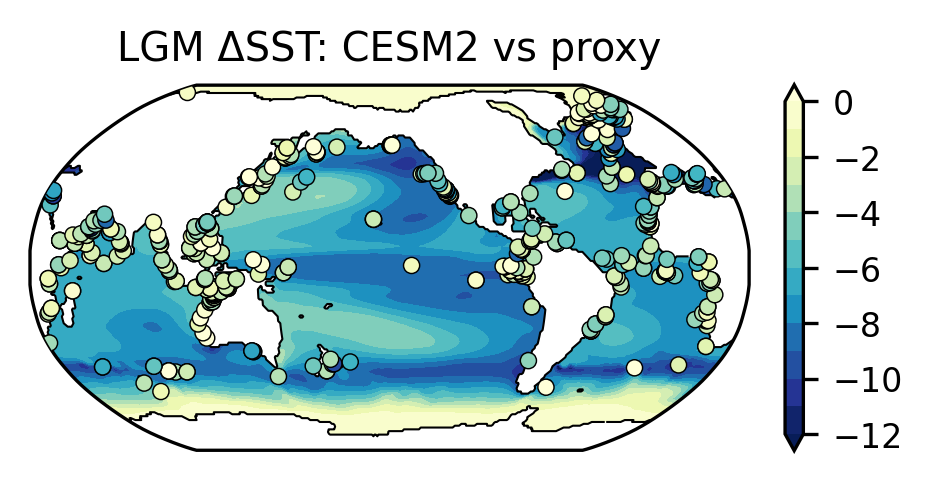

In [9]:
cmap = plt.get_cmap('YlGnBu').reversed()
norm = mpl.colors.Normalize(-12, 0)

fig, ax = plt.subplots(nrows=1, ncols=1,
                       figsize=(3, 1.5),
                       subplot_kw={'projection': ccrs.Robinson(central_longitude=210)},
                       constrained_layout=True)

# Plot model results using contourf
dsst_1x1_new, lon_new = add_cyclic_point(dsst_1x1, dsst_1x1.lon)
p0 = ax.contourf(lon_new, dsst_1x1.lat, dsst_1x1_new,
                 levels=np.linspace(-12, 0, 13),
                 cmap=cmap, norm=norm, extend='both',
                 transform=ccrs.PlateCarree())
plt.colorbar(p0, ax=ax)

# Create a land-sea mask and plot the LGM coastal line
lmask = xr.where(dsst_1x1.isnull(), 0, 1)
ax.contour(lmask.lon, lmask.lat, lmask,
           levels=[0.5],
           linewidths=0.5,
           colors='black',
           transform=ccrs.PlateCarree())

# Plot proxy SST using markers
ax.scatter(proxy_dsst['Longitude'],
           proxy_dsst['Latitude'],
           c=proxy_dsst['Median'],
           marker='o',
           s=15,
           cmap=cmap,
           edgecolors='black',
           lw=0.35,
           norm=norm,
           zorder=3,
           transform=ccrs.PlateCarree())

ax.set_title("LGM ΔSST: CESM2 vs proxy")

---
## Example 2: Access ERA5 Reanalysis data on NSF NCAR's Research Data Archive
Browse the [RDA website](https://rda.ucar.edu/) and figure out the file structure
- Search `era5`
- Click the `Monthly Mean` product (ds633.1)
- Click the tab `DATA ACCESS`
- Total precipitation is in `ERA5 monthly mean atmospheric surface forecast (accumulated) [netCDF4]`
- Click `GLADE File Listing` to see all the files stored on the NCAR Campaign Storage 

In [10]:
data_dir = '/glade/campaign/collections/rda/data/ds633.1/e5.moda.fc.sfc.accumu/'

files_tp = glob.glob(data_dir + '*/*_tp.*.nc')
print(*files_tp, sep='\n')

/glade/campaign/collections/rda/data/ds633.1/e5.moda.fc.sfc.accumu/2003/e5.moda.fc.sfc.accumu.128_228_tp.ll025sc.2003010100_2003120100.nc
/glade/campaign/collections/rda/data/ds633.1/e5.moda.fc.sfc.accumu/2018/e5.moda.fc.sfc.accumu.128_228_tp.ll025sc.2018010100_2018120100.nc
/glade/campaign/collections/rda/data/ds633.1/e5.moda.fc.sfc.accumu/2004/e5.moda.fc.sfc.accumu.128_228_tp.ll025sc.2004010100_2004120100.nc
/glade/campaign/collections/rda/data/ds633.1/e5.moda.fc.sfc.accumu/2019/e5.moda.fc.sfc.accumu.128_228_tp.ll025sc.2019010100_2019120100.nc
/glade/campaign/collections/rda/data/ds633.1/e5.moda.fc.sfc.accumu/2005/e5.moda.fc.sfc.accumu.128_228_tp.ll025sc.2005010100_2005120100.nc
/glade/campaign/collections/rda/data/ds633.1/e5.moda.fc.sfc.accumu/2006/e5.moda.fc.sfc.accumu.128_228_tp.ll025sc.2006010100_2006120100.nc
/glade/campaign/collections/rda/data/ds633.1/e5.moda.fc.sfc.accumu/1979/e5.moda.fc.sfc.accumu.128_228_tp.ll025sc.1979010100_1979120100.nc
/glade/campaign/collections/rda/da

In [11]:
ds = xr.open_mfdataset(files_tp)
ds = ds.reindex(latitude=sorted(ds.latitude.values))
ds

<xarray.Dataset>
Dimensions:    (latitude: 721, longitude: 1440, time: 528)
Coordinates:
  * latitude   (latitude) float64 -90.0 -89.75 -89.5 -89.25 ... 89.5 89.75 90.0
  * longitude  (longitude) float64 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2022-12-01
Data variables:
    TP         (time, latitude, longitude) float32 dask.array<chunksize=(3, 332, 776), meta=np.ndarray>
    utc_date   (time) int32 dask.array<chunksize=(12,), meta=np.ndarray>
Attributes:
    DATA_SOURCE:          ECMWF: https://cds.climate.copernicus.eu, Copernicu...
    NETCDF_CONVERSION:    CISL RDA: Conversion from ECMWF GRIB 1 data to netC...
    NETCDF_VERSION:       4.6.1
    CONVERSION_PLATFORM:  Linux casper02 3.10.0-693.21.1.el7.x86_64 #1 SMP We...
    CONVERSION_DATE:      Mon Nov 11 08:45:33 MST 2019
    Conventions:          CF-1.6
    NETCDF_COMPRESSION:   NCO: Precision-preserving compression to netCDF4/HD...
    history:              Mon Nov 11 08:45:34 2019: ncks -4 --ppc default=7 e...
    NCO:                  netCDF Operators version 4.7.9 (Homepage = http://n...

### Change the units from m per day to mm per day and make a plot
See [here](https://confluence.ecmwf.int/pages/viewpage.action?pageId=197702790) for clarification of units.

In [12]:
tp = ds.TP.mean('time') * 1000.0
tp = tp.compute()
tp

<xarray.DataArray 'TP' (latitude: 721, longitude: 1440)>
array([[0.18871191, 0.18871191, 0.18871191, ..., 0.18871191, 0.18871191,
        0.18871191],
       [0.1763593 , 0.17630874, 0.17631234, ..., 0.17640808, 0.17640086,
        0.17640446],
       [0.17613353, 0.17612088, 0.17608838, ..., 0.17611367, 0.17612632,
        0.17613533],
       ...,
       [0.6987416 , 0.69886446, 0.6989421 , ..., 0.6986495 , 0.69864047,
        0.69868386],
       [0.7080526 , 0.7081086 , 0.70814294, ..., 0.70803094, 0.7080472 ,
        0.70808154],
       [0.7012306 , 0.7012306 , 0.7012306 , ..., 0.7012306 , 0.7012306 ,
        0.7012306 ]], dtype=float32)
Coordinates:
  * latitude   (latitude) float64 -90.0 -89.75 -89.5 -89.25 ... 89.5 89.75 90.0
  * longitude  (longitude) float64 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8

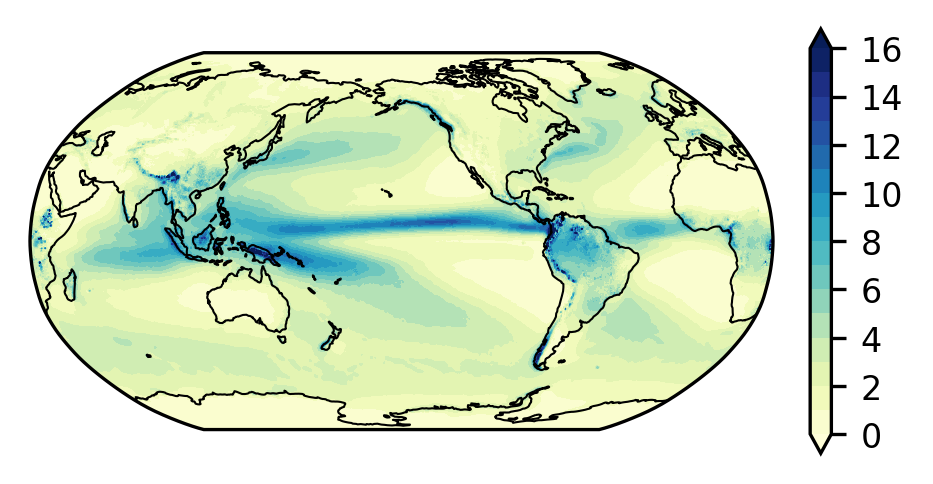

In [13]:
fig, ax = plt.subplots(
    nrows=1, ncols=1,
    figsize=(3, 1.5),
    subplot_kw={'projection': ccrs.Robinson(central_longitude=210)},
    constrained_layout=True)

# Plot model results using contourf
p0 = ax.contourf(tp.longitude, tp.latitude, tp,
                 levels=np.linspace(0, 16, 17),
                 cmap='YlGnBu', extend='both',
                 transform=ccrs.PlateCarree())
plt.colorbar(p0, ax=ax)
ax.coastlines(linewidth=0.5)

---
## Example 3: Plot AMOC from TraCE and compare with McManus et al. 2004
- TraCE data is directly accessible on NCAR machines: `/glade/campaign/cesm/collections/TraCE`

In [14]:
file = '/glade/campaign/cesm/collections/TraCE/ocn/proc/tavg/decadal/trace.01-36.22000BP.pop.MOC.22000BP_decavg_400BCE.nc'

ds = xr.open_dataset(file)
ds

<xarray.Dataset>
Dimensions:               (nlat: 116, nlon: 100, time: 2204, transport_reg: 2,
                           moc_comp: 1, moc_z: 26, lat_aux_grid: 105, z_t: 25,
                           z_w: 25, transport_comp: 3)
Coordinates:
    TLAT                  (nlat, nlon) float32 ...
    TLONG                 (nlat, nlon) float32 ...
    ULAT                  (nlat, nlon) float32 ...
    ULONG                 (nlat, nlon) float32 ...
  * lat_aux_grid          (lat_aux_grid) float32 -80.26 -78.73 ... 88.38 90.0
    moc_components        (moc_comp) |S256 ...
  * moc_z                 (moc_z) float32 0.0 800.0 ... 4.503e+05 5e+05
  * time                  (time) float64 -22.0 -21.99 -21.98 ... 0.01 0.02 0.03
    transport_regions     (transport_reg) |S256 ...
  * z_t                   (z_t) float32 400.0 1.222e+03 ... 4.255e+05 4.751e+05
  * z_w                   (z_w) float32 0.0 800.0 ... 4.007e+05 4.503e+05
Dimensions without coordinates: nlat, nlon, transport_reg, moc_comp,
                                transport_comp
Data variables: (12/51)
    ANGLE                 (nlat, nlon) float32 ...
    ANGLET                (nlat, nlon) float32 ...
    DXT                   (nlat, nlon) float32 ...
    DXU                   (nlat, nlon) float32 ...
    DYT                   (nlat, nlon) float32 ...
    DYU                   (nlat, nlon) float32 ...
    ...                    ...
    sea_ice_salinity      float64 ...
    sflux_factor          float64 ...
    sound                 float64 ...
    stefan_boltzmann      float64 ...
    transport_components  (transport_comp) |S256 ...
    vonkar                float64 ...
Attributes:
    title:                     b30.22_0kaDVT
    contents:                  Diagnostic and Prognostic Variables
    source:                    POP, the NCAR/CSM Ocean Component
    revision:                   $Name: ccsm3_0_1_beta22 $
    calendar:                  All years have exactly  365 days.
    conventions:               CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netc...
    start_time:                This dataset was created on 2007-07-29 at 23:1...
    cell_methods:              cell_methods = time: mean ==> the variable val...
    history:                   Fri Nov  8 22:51:40 2013: /glade/apps/opt/nco/...
    nco_openmp_thread_number:  1
    NCO:                       4.3.2

### Meridional Overturning Circulation is `MOC`, a 5-dimentional variable
- `transport_components` has three components: (1) Total, (2) Eulerian-Mean Advection, and (3) Eddy-Induced Advection (bolus) + Diffusion
- `moc_comp` of `MOC` is 0, which means the MOC caculation is the (1) total transport
- `transport_regions` has two parts: (1) Global Ocean - Marginal Seas and (2) Atlantic Ocean + Labrador Sea + GIN Sea + Arctic Ocean
- `transport_reg` of `MOC` are 0 and 1, which indicate MOC values for Global Ocean and the Atlantic Ocean, respectively
- Note that the depth, `moc_z`, is in centimeter

In [15]:
ds.MOC

<xarray.DataArray 'MOC' (time: 2204, transport_reg: 2, moc_comp: 1, moc_z: 26,
                         lat_aux_grid: 105)>
[12033840 values with dtype=float32]
Coordinates:
  * lat_aux_grid       (lat_aux_grid) float32 -80.26 -78.73 ... 88.38 90.0
    moc_components     (moc_comp) |S256 ...
  * moc_z              (moc_z) float32 0.0 800.0 1.644e+03 ... 4.503e+05 5e+05
  * time               (time) float64 -22.0 -21.99 -21.98 ... 0.01 0.02 0.03
    transport_regions  (transport_reg) |S256 ...
Dimensions without coordinates: transport_reg, moc_comp
Attributes:
    long_name:  Meridional Overturning Circulation
    units:      Sverdrups

In [16]:
ds.transport_regions.values

array([b'Global Ocean - Marginal Seas',
       b'Atlantic Ocean + Labrador Sea + GIN Sea + Arctic Ocean'],
      dtype='|S256')

In [17]:
ds.MOC.transport_reg.values

array([0, 1])

In [18]:
ds.transport_components.values

array([b'Total', b'Eulerian-Mean Advection',
       b'Eddy-Induced Advection (bolus) + Diffusion'], dtype='|S256')

In [19]:
ds.MOC.moc_comp.values

array([0])

### The left and right plots are the global mean and Atlantic MOC, respectively

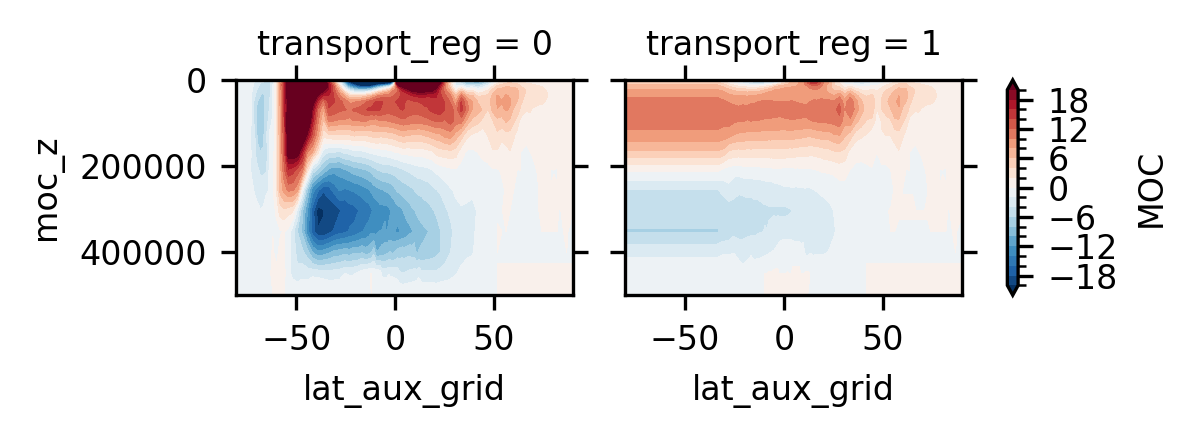

In [20]:
ds.MOC.isel(time=slice(0, 10), moc_comp=0).mean('time').plot.contourf(
    size=1.5, x='lat_aux_grid', y='moc_z', col='transport_reg',
    levels=np.linspace(-20, 20, 21))
plt.gca().invert_yaxis()

### Again, `transport_reg=1` means Atlantic and `moc_comp=0` means the total transport 

In [21]:
amoc = ds.MOC.isel(transport_reg=1, moc_comp=0)
amoc

<xarray.DataArray 'MOC' (time: 2204, moc_z: 26, lat_aux_grid: 105)>
[6016920 values with dtype=float32]
Coordinates:
  * lat_aux_grid       (lat_aux_grid) float32 -80.26 -78.73 ... 88.38 90.0
    moc_components     |S256 ...
  * moc_z              (moc_z) float32 0.0 800.0 1.644e+03 ... 4.503e+05 5e+05
  * time               (time) float64 -22.0 -21.99 -21.98 ... 0.01 0.02 0.03
    transport_regions  |S256 b'Atlantic Ocean + Labrador Sea + GIN Sea + Arct...
Attributes:
    long_name:  Meridional Overturning Circulation
    units:      Sverdrups

### We define AMOC time series as the maximum over the North Atlantic and beneath a depth of 500 m (to avoid the wind-drive cell)

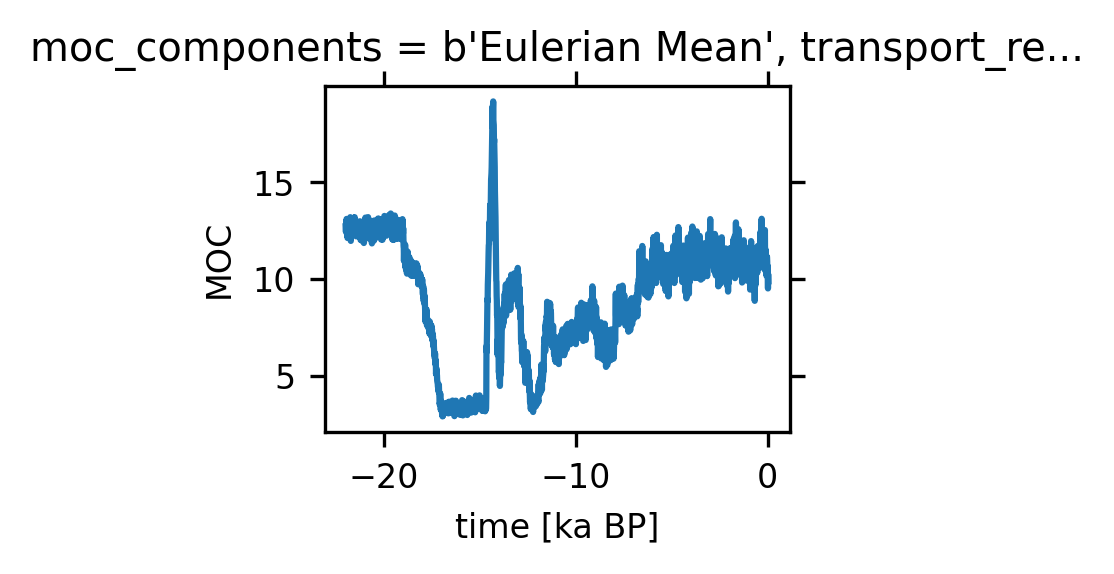

In [22]:
amoc_ts = amoc.sel(moc_z=slice(50000, 500000),
                   lat_aux_grid=slice(0, 90)).max(('moc_z', 'lat_aux_grid'))
amoc_ts.plot(size=1.5)

### Load the McManus et al. (2004) data from NOAA

In [23]:
McManus04 = 'https://www.ncei.noaa.gov/pub/data/paleo/paleocean/sediment_files/complete/o326-gc5-tab.txt'
pa_th = pd.read_table(McManus04, header=37)

# Replace missing values
pa_th = pa_th[pa_th["pa/th232"] != -999].reset_index(drop=True)
pa_th.head()

,depth,calyrBP,pa/th232,pa/th232.err,pa/th238,pa/th238.err,d18Og.infla,Unnamed: 7
0,-999,100,0.054,0.002,0.055,0.002,-999.00,NaN
1,-999,480,0.054,0.002,0.054,0.002,-999.00,NaN
2,-999,960,0.057,0.004,0.057,0.004,0.66,NaN
3,-999,1430,0.054,0.002,0.054,0.002,-999.00,NaN
4,-999,1910,0.055,0.002,0.055,0.002,0.63,NaN


In [24]:
# Change the time to be consistent with TraCE
pa_th['time'] = pa_th['calyrBP '] / -1000.0
pa_th.head()

,depth,calyrBP,pa/th232,pa/th232.err,pa/th238,pa/th238.err,d18Og.infla,Unnamed: 7,time
0,-999,100,0.054,0.002,0.055,0.002,-999.00,NaN,-0.10
1,-999,480,0.054,0.002,0.054,0.002,-999.00,NaN,-0.48
2,-999,960,0.057,0.004,0.057,0.004,0.66,NaN,-0.96
3,-999,1430,0.054,0.002,0.054,0.002,-999.00,NaN,-1.43
4,-999,1910,0.055,0.002,0.055,0.002,0.63,NaN,-1.91


### Plot time series

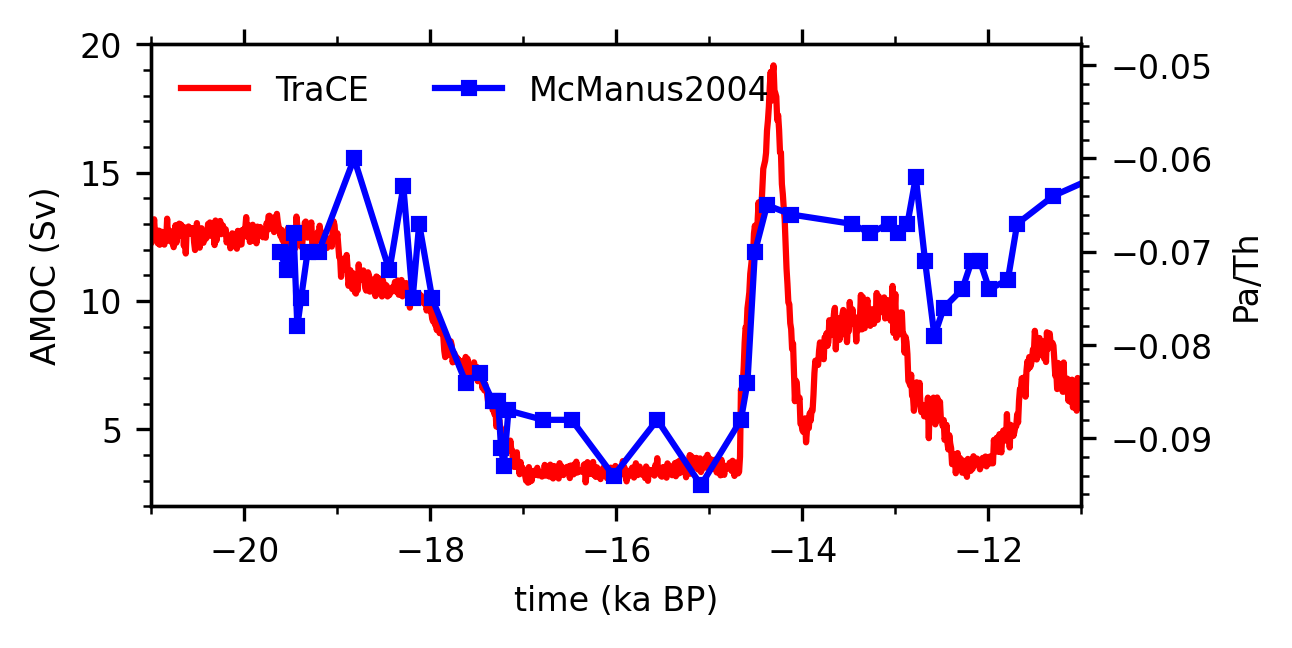

In [25]:
fig, ax = plt.subplots(figsize=(4, 2))

# Plot the AMOC time series in TraCE
ax.plot(amoc_ts.time, amoc_ts, 'red',
        label='TraCE')
ax.set_xlim([-21, -11])
ax.set_ylim([2, 20])
ax.set_xlabel('time (ka BP)')
ax.set_ylabel('AMOC (Sv)')
ax.xaxis.set_major_locator(plt.MultipleLocator(2))
ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(5))
ax.yaxis.set_minor_locator(plt.MultipleLocator(1))

# Plot the Pa/Th time series in McManus et al. (2004)
ax2 = ax.twinx()
ax2.plot(pa_th['time'], pa_th['pa/th238']*-1,
         'blue',
         marker='s', markersize=3,
         label='McManus2004')
ax2.set_ylabel('Pa/Th')
ax2.yaxis.set_major_locator(plt.MultipleLocator(0.01))
ax2.yaxis.set_minor_locator(plt.MultipleLocator(0.002))

# Add a legend
lh1, ll1 = ax.get_legend_handles_labels()
lh2, ll2 = ax2.get_legend_handles_labels()
leg = ax.legend(lh1+lh2, ll1+ll2, frameon=False,
                loc='upper left',  ncol=2, fontsize=8)

---
## Example 4. Compute and plot precipitation δ18O
- We define a function to compute precipitation δ18O

In [26]:
def calculate_d18Op(ds):
    """
    Compute precipitation δ18O with iCESM output

    Parameters
    ds: xarray.Dataset contains necessary variables

    Returns
    ds: xarray.Dataset with δ18O added
    """

    # convective & large-scale rain and snow, respectively
    p16O = ds.PRECRC_H216Or + ds.PRECSC_H216Os + ds.PRECRL_H216OR + ds.PRECSL_H216OS
    p18O = ds.PRECRC_H218Or + ds.PRECSC_H218Os + ds.PRECRL_H218OR + ds.PRECSL_H218OS

    # avoid dividing by small number here
    p18O = p18O.where(p16O > 1.E-18, 1.E-18)
    p16O = p16O.where(p16O > 1.E-18, 1.E-18)
    d18O = (p18O / p16O - 1.0) * 1000.0

    ds['p16O'] = p16O
    ds['p18O'] = p18O
    ds['d18O'] = d18O

    return ds

- Figure out the file names

In [27]:
!ls /glade/campaign/cgd/ppc/jiangzhu/iCESM1.2/b.e12.B1850C5.f19_g16.iPI.01/atm/proc/tseries/month_1/*PRECRC_H218Or*
!ls /glade/campaign/cgd/ppc/jiangzhu/iCESM1.2/b.e12.B1850C5.f19_g16.i21ka.03/atm/proc/tseries/month_1/*PRECRC_H218Or*

/glade/campaign/cgd/ppc/jiangzhu/iCESM1.2/b.e12.B1850C5.f19_g16.iPI.01/atm/proc/tseries/month_1/b.e12.B1850C5.f19_g16.iPI.01.cam.h0.PRECRC_H218Or.0001-0900.cal_adj.nc
/glade/campaign/cgd/ppc/jiangzhu/iCESM1.2/b.e12.B1850C5.f19_g16.iPI.01/atm/proc/tseries/month_1/b.e12.B1850C5.f19_g16.iPI.01.cam.h0.PRECRC_H218Or.0001-0900.nc


/glade/campaign/cgd/ppc/jiangzhu/iCESM1.2/b.e12.B1850C5.f19_g16.i21ka.03/atm/proc/tseries/month_1/b.e12.B1850C5.f19_g16.i21ka.03.cam.h0.PRECRC_H218Or.0001-0900.cal_adj.nc
/glade/campaign/cgd/ppc/jiangzhu/iCESM1.2/b.e12.B1850C5.f19_g16.i21ka.03/atm/proc/tseries/month_1/b.e12.B1850C5.f19_g16.i21ka.03.cam.h0.PRECRC_H218Or.0001-0900.nc


* We need to read in all these variables

In [28]:
vnames = ['PRECC', 'PRECL',
          'PRECRC_H216Or', 'PRECSC_H216Os', 'PRECRL_H216OR', 'PRECSL_H216OS',
          'PRECRC_H218Or', 'PRECSC_H218Os', 'PRECRL_H218OR', 'PRECSL_H218OS']

In [29]:
storage_dir = '/glade/campaign/cgd/ppc/jiangzhu/iCESM1.2/'
hist_dir = '/atm/proc/tseries/month_1/'

case_pre = 'b.e12.B1850C5.f19_g16.iPI.01'
case_lgm = 'b.e12.B1850C5.f19_g16.i21ka.03'

fnames_pre = []
fnames_lgm = []

for vname in vnames:

    fname = glob.glob(storage_dir + case_pre + hist_dir + '*' + vname + '.0001-0900.nc')
    fnames_pre.extend(fname)

    fname = glob.glob(storage_dir + case_lgm + hist_dir + '*' + vname + '.0001-0900.nc')
    fnames_lgm.extend(fname)

print(*fnames_pre, sep='\n')
print(*fnames_lgm, sep='\n')

/glade/campaign/cgd/ppc/jiangzhu/iCESM1.2/b.e12.B1850C5.f19_g16.iPI.01/atm/proc/tseries/month_1/b.e12.B1850C5.f19_g16.iPI.01.cam.h0.PRECC.0001-0900.nc
/glade/campaign/cgd/ppc/jiangzhu/iCESM1.2/b.e12.B1850C5.f19_g16.iPI.01/atm/proc/tseries/month_1/b.e12.B1850C5.f19_g16.iPI.01.cam.h0.PRECL.0001-0900.nc
/glade/campaign/cgd/ppc/jiangzhu/iCESM1.2/b.e12.B1850C5.f19_g16.iPI.01/atm/proc/tseries/month_1/b.e12.B1850C5.f19_g16.iPI.01.cam.h0.PRECRC_H216Or.0001-0900.nc
/glade/campaign/cgd/ppc/jiangzhu/iCESM1.2/b.e12.B1850C5.f19_g16.iPI.01/atm/proc/tseries/month_1/b.e12.B1850C5.f19_g16.iPI.01.cam.h0.PRECSC_H216Os.0001-0900.nc
/glade/campaign/cgd/ppc/jiangzhu/iCESM1.2/b.e12.B1850C5.f19_g16.iPI.01/atm/proc/tseries/month_1/b.e12.B1850C5.f19_g16.iPI.01.cam.h0.PRECRL_H216OR.0001-0900.nc
/glade/campaign/cgd/ppc/jiangzhu/iCESM1.2/b.e12.B1850C5.f19_g16.iPI.01/atm/proc/tseries/month_1/b.e12.B1850C5.f19_g16.iPI.01.cam.h0.PRECSL_H216OS.0001-0900.nc
/glade/campaign/cgd/ppc/jiangzhu/iCESM1.2/b.e12.B1850C5.f19_g1

In [30]:
%%time

ds_pre = xr.open_mfdataset(fnames_pre, parallel=True,
                           data_vars='minimal',
                           coords='minimal',
                           compat='override',
                           chunks={'time':12}).isel(time=slice(-120, None))

ds_lgm = xr.open_mfdataset(fnames_lgm, parallel=True,
                           data_vars='minimal',
                           coords='minimal',
                           compat='override',
                           chunks={'time':12}).isel(time=slice(-120, None))

CPU times: user 1.27 s, sys: 132 ms, total: 1.4 s
Wall time: 4.07 s


In [31]:
ds_pre = calculate_d18Op(ds_pre)
ds_lgm = calculate_d18Op(ds_lgm)
ds_pre

<xarray.Dataset>
Dimensions:        (lev: 30, ilev: 31, lat: 96, lon: 144, slat: 95, slon: 144,
                    time: 120, nbnd: 2)
Coordinates:
  * lev            (lev) float64 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * ilev           (ilev) float64 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
  * lat            (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon            (lon) float64 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * slat           (slat) float64 -89.05 -87.16 -85.26 ... 85.26 87.16 89.05
  * slon           (slon) float64 -1.25 1.25 3.75 6.25 ... 351.2 353.8 356.2
  * time           (time) object 0891-02-01 00:00:00 ... 0901-01-01 00:00:00
Dimensions without coordinates: nbnd
Data variables: (12/44)
    hyam           (lev) float64 dask.array<chunksize=(30,), meta=np.ndarray>
    hybm           (lev) float64 dask.array<chunksize=(30,), meta=np.ndarray>
    hyai           (ilev) float64 dask.array<chunksize=(31,), meta=np.ndarray>
    hybi           (ilev) float64 dask.array<chunksize=(31,), meta=np.ndarray>
    P0             float64 ...
    w_stag         (slat) float64 dask.array<chunksize=(95,), meta=np.ndarray>
    ...             ...
    PRECSC_H218Os  (time, lat, lon) float32 dask.array<chunksize=(12, 96, 144), meta=np.ndarray>
    PRECSL_H216OS  (time, lat, lon) float32 dask.array<chunksize=(12, 96, 144), meta=np.ndarray>
    PRECSL_H218OS  (time, lat, lon) float32 dask.array<chunksize=(12, 96, 144), meta=np.ndarray>
    p16O           (time, lat, lon) float32 dask.array<chunksize=(12, 96, 144), meta=np.ndarray>
    p18O           (time, lat, lon) float32 dask.array<chunksize=(12, 96, 144), meta=np.ndarray>
    d18O           (time, lat, lon) float32 dask.array<chunksize=(12, 96, 144), meta=np.ndarray>
Attributes:
    Conventions:      CF-1.0
    source:           CAM
    case:             b.e12.B1850C5.f19_g16.iPI.01
    title:            UNSET
    logname:          jiangzhu
    host:             r5i1n15
    Version:          $Name$
    revision_Id:      $Id$
    initial_file:     b.ie12.B1850C5CN.f19_g16.09.cam.i.0401-01-01-00000.nc
    topography_file:  /glade/p/cesmdata/cseg/inputdata/atm/cam/topo/USGS-gtop...

In [32]:
# Save netcdf data
# ds_pre.to_netcdf('dataset_with_d18Op.nc')

In [33]:
d18Op_pre = ds_pre.d18O.mean('time')
d18Op_lgm = ds_lgm.d18O.mean('time')

# Sometimes, it is preferred to use the precipitation-amount weighted d18O
#d18Op_pre = ds_pre.d18O.weighted(ds_pre.p16O).mean('time')

d18Op_pre

<xarray.DataArray 'd18O' (lat: 96, lon: 144)>
dask.array<mean_agg-aggregate, shape=(96, 144), dtype=float32, chunksize=(96, 144), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5

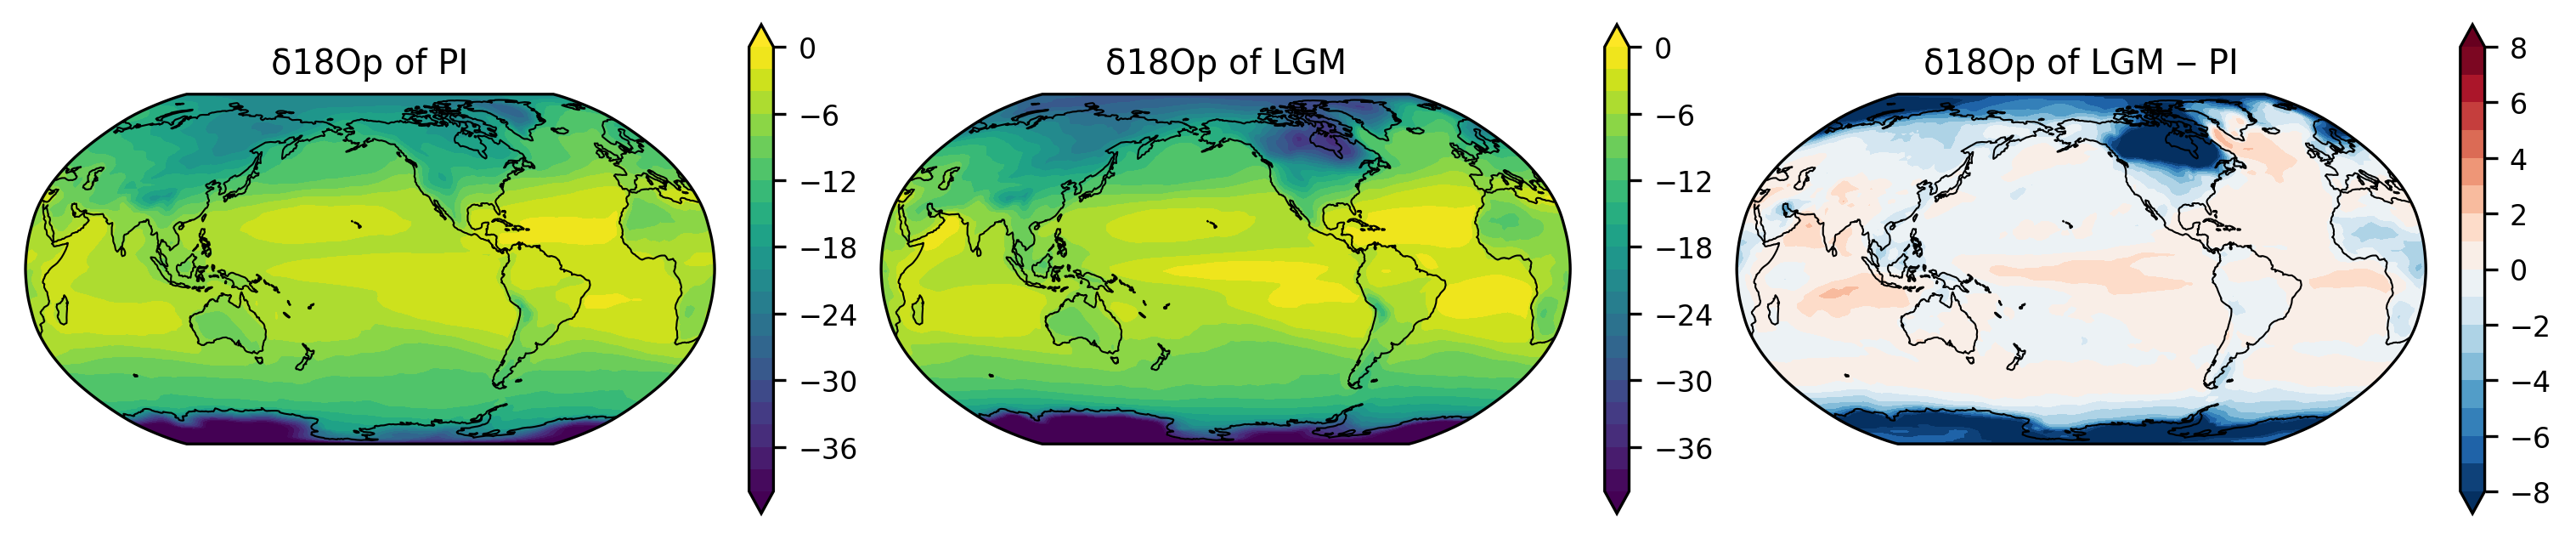

In [34]:
fig, axes = plt.subplots(1, 3,
                         figsize=(10, 2),
                         subplot_kw={'projection': ccrs.Robinson(central_longitude=210)},
                         constrained_layout=True)
axes = axes.ravel()

lon = d18Op_pre.lon
lat = d18Op_pre.lat

ax = axes[0]
var_new, lon_new = add_cyclic_point(d18Op_pre, lon)
p0 = ax.contourf(lon_new, lat, var_new,
                 levels=np.linspace(-40, 0, 21),
                 extend='both',
                 transform=ccrs.PlateCarree())
plt.colorbar(p0, ax=ax)
ax.set_title("δ18Op of PI")

ax = axes[1]
var_new, lon_new = add_cyclic_point(d18Op_lgm, lon)
p1 = ax.contourf(lon_new, lat, var_new,
                 levels=np.linspace(-40, 0, 21),
                 extend='both',
                 transform=ccrs.PlateCarree())
plt.colorbar(p1, ax=ax)
ax.set_title("δ18Op of LGM")

ax = axes[2]
var_diff = d18Op_lgm - d18Op_pre
var_new, lon_new = add_cyclic_point(var_diff, lon)

p2 = ax.contourf(lon_new, lat, var_new,
                 cmap='RdBu_r',
                 levels=np.linspace(-8, 8, 17),
                 extend='both',
                 transform=ccrs.PlateCarree())
plt.colorbar(p2, ax=ax)
ax.set_title("δ18Op of LGM ‒ PI")

for ax in axes:
    ax.set_global()
    ax.coastlines(linewidth=0.5)